In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import pandas as pd

from library.snr import optimal_snr
from library.lisa_response_fastGB import tdi_XYZ_fastGB, tdi_AE_fastGB
from library.lisa_psd import noise_psd_XYZ, noise_psd_AE, noise_psd_AE_gal, noise_psd_AE_gal2


Set up detector's parameters and load GB data

In [2]:
detector_params = {
    'L' : 2.5e9/constants.c,
    'T_obs' : 4*365*24*3600, 
    'N' : 2**10,
    'delta_t' : 5,
    'tdi': 1.5
}


catalog = pd.read_csv("data/VGB.csv")

catalog.rename(columns={
    "Frequency": "f0",
    "FrequencyDerivative": "f_dot",
    "Amplitude": "ampl",
    "EclipticLatitude": "bet",
    "EclipticLongitude": "lam",
    "Polarization": "psi",
    "Inclination": "inclination",
    "InitialPhase": "phi0",
    "Mass1": "mass1",
    "Mass2": "mass2"
}, inplace=True)


# markdown with SNR reference values 
df_ref = pd.read_csv("data/VGB.md", sep="|", skipinitialspace=True, comment="#")
df_ref = df_ref.dropna(axis=1, how="all")
df_ref = df_ref.loc[:, ~df_ref.columns.str.contains('^Unnamed')]

In [3]:
import re

def parse_snr_range(s):
    if s is None:
        return [None, None]

    s = str(s)

    s = s.replace("–", "-").replace("—", "-")

    # Extract all numeric values 
    nums = re.findall(r"\d+(?:\.\d+)?", s)

    if len(nums) >= 2:
        return [float(nums[0]), float(nums[1])]
    elif len(nums) == 1:
        val = float(nums[0])
        return [val, val]
    else:
        return [None, None]


In [4]:
from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE_confusion


snr_list = []
snr_list_gal = []
snr_list_gal2=[]
snr_list_pycbc = []
#L = detector_params['L']


/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [19]:
for _, row in catalog.iterrows():
    binary_params = row.to_dict()
    params = {**detector_params, **binary_params}
    f0 = params['f0']*1e3
    A,E,kmin,fr = tdi_AE_fastGB(**params)
    psd = noise_psd_AE( fr,  **params)
    psd_gal = noise_psd_AE_gal( fr, **params)
    psd_gal2 = noise_psd_AE_gal2( fr, **params)
    psd_pycbc = analytical_psd_lisa_tdi_AE_confusion(len(fr), delta_f= 1e-5, low_freq_cutoff=1e-5, duration = 4, tdi=1.5)

    snr_value = optimal_snr(A, psd, **params).round(2)
    snr_value_gal = optimal_snr(A, psd_gal, **params).round(2)
    snr_value_gal2 = optimal_snr(A, psd_gal2, **params).round(2)
    snr_value_pycbc = optimal_snr(A, psd_pycbc, **params).round(2)

    ref_row = df_ref.loc[df_ref['Source    '].str.strip() == params['Name']]
    if not ref_row.empty:
        snr_pred_str = ref_row['SNR_4yr (updated curve) '].values[0]
        snr_pred = parse_snr_range(snr_pred_str)
    else:
        snr_pred = None  
    snr_list.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value, 'SNR predicted': snr_pred})
    snr_list_gal.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value_gal, 'SNR predicted': snr_pred})
    snr_list_gal2.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value_gal2, 'SNR predicted': snr_pred})
    snr_list_pycbc.append({'Name': params['Name'], 'Frequency': f0, 'SNR': snr_value_pycbc, 'SNR predicted': snr_pred})
    

# print(snr_list)

snr_df = pd.DataFrame(snr_list)
# snr_df.sort_values(by="SNR", ascending=False, inplace=True)
#print(snr_df)

# Option to save results as tables
#snr_df.to_latex("snr_table.tex", index=False)
#snr_df.to_csv("snr_results.csv", index=False)



/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/psd/read.py:76: RuntimeWarning: divide by zero encountered in log
  slog = numpy.log(noise_data)
/home/alice/miniforge3/envs/gwpy_env/lib/python3.12/site-packages/pycbc/types/array.py:217: RuntimeWarning: divide by zero encountered in divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)
/home/alice/Master-thesis-/library/snr.py:24: RuntimeWarning: invalid value encountered in scalar multiply
  return 4 / duration * integrand.sum()


confusion from: http://arxiv.org/abs/1803.01944

confusion 2 from: https://link.aps.org/doi/10.1103/lk4h-lz7y 

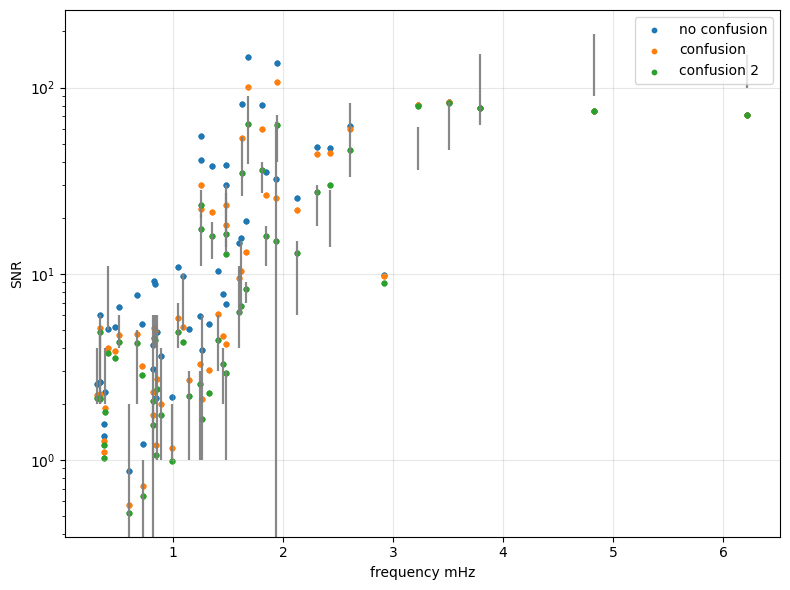

In [27]:
freqs = [d["Frequency"] for d in snr_list]
snr1 = [d["SNR"] for d in snr_list]
snr2 = [d["SNR"] for d in snr_list_gal]
snr3 = [d["SNR"] for d in snr_list_gal2]
snr4 = [d["SNR"] for d in snr_list_pycbc]



for d in snr_list:
    d["SNR predicted"] = parse_snr_range(d["SNR predicted"])


# Create figure
plt.figure(figsize=(8, 6))

# Plot SNR vs frequency for both lists
plt.scatter(freqs, snr1, s=10, label='no confusion')
plt.scatter(freqs, snr2, s=10,  label='confusion')
plt.scatter(freqs, snr3, s=10, label='confusion 2')
#plt.scatter(freqs, snr4, s=10, label='confusion pycbc')
for d in snr_list:
    f = d["Frequency"]
    smin, smax = d["SNR predicted"]
    if None not in (smin, smax):
        plt.vlines(
            f, smin, smax,
            color='gray',
            alpha=0.6,
            linewidth=1.5,
            zorder=2
        )

plt.xlabel('frequency mHz')
plt.ylabel('SNR')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
from pycbc.psd.analytical_space import semi_analytical_psd_lisa_confusion_noise
from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE
from library.lisa_psd import S_gal, S_gal2
from pycbc.psd.analytical_space import analytical_psd_lisa_tdi_AE_confusion

L = detector_params['L']
fmin = 1e-5
fmax = 0.1
df = 1e-5
#fra = np.logspace(-5, 0, 1000)
fra = np.arange(fmin, fmax, df)

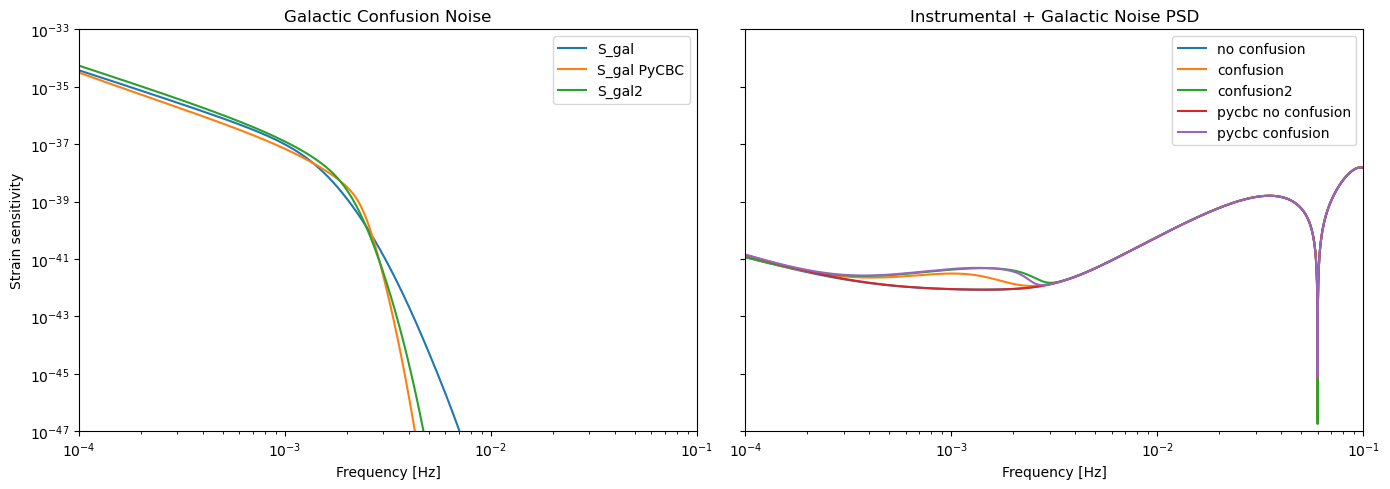

In [26]:
from pycbc.psd.analytical_space import confusion_fit_lisa

psd = noise_psd_AE_gal(fra, 2.5e9/constants.c, tdi=1.5)
psd_nog = noise_psd_AE(fra,2.5e9/constants.c, tdi=1.5)
psd2 = noise_psd_AE_gal2(fra, 2.5e9/constants.c, 4, tdi=1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

ax1.loglog(fra, S_gal(fra, L),           label="S_gal")
ax1.loglog(fra, confusion_fit_lisa(len(fra), df, fmin, duration=4), label="S_gal PyCBC")
ax1.loglog(fra, S_gal2(fra, L, 4), label="S_gal2")

ax1.set_title("Galactic Confusion Noise")
ax1.set_xlim(1e-4, 1e-1)
ax1.set_ylim(1e-47, 1e-33)
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Strain sensitivity")
ax1.legend()

# -------------------------------------------------------------
ax2.loglog(fra, psd_nog, label="no confusion")
ax2.loglog(fra, psd,     label="confusion")
ax2.loglog(fra, psd2, label='confusion2')
ax2.loglog(fra, analytical_psd_lisa_tdi_AE(len(fra), df, fmin,tdi=1.5), label='pycbc no confusion')
ax2.loglog(fra, analytical_psd_lisa_tdi_AE_confusion(len(fra), df, fmin,tdi=1.5, duration=4), label='pycbc confusion')

ax2.set_title("Instrumental + Galactic Noise PSD")
ax2.set_xlabel("PSD")
ax2.set_xlim(1e-4, 1e-1)
ax2.set_ylim(1e-47, 1e-33)
ax2.set_xlabel("Frequency [Hz]")
ax2.legend()

plt.tight_layout()
plt.show()

